In [1]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset_org import get_rays
from rendering import rendering
from model import Voxels, Nerf
from ml_helpers import training

# Camera / Dataset

In [ ]:
import torch
from torch.utils.data import DataLoader

# Batch size
batch_size = 1024
data_dir = "data/17818_views100"
# Fetch rays (might be [N,H,W,3], [H,W,3], or already flattened [M,3])
o, d, target_px_values = get_rays(datapath=data_dir, mode="train")

print(f"Fetched o.shape={o.shape}, dims={o.ndim}")

# Dynamically flatten for training
o_flat, d_flat, t_flat = None, None, None
if o.ndim == 4:
    N, H, W, C = o.shape
    o_flat = torch.from_numpy(o).reshape(-1, C).float()
    d_flat = torch.from_numpy(d).reshape(-1, C).float()
    t_flat = torch.from_numpy(target_px_values).reshape(-1, C).float()
elif o.ndim == 3:
    H, W, C = o.shape
    o_flat = torch.from_numpy(o).reshape(-1, C).float()
    d_flat = torch.from_numpy(d).reshape(-1, C).float()
    t_flat = torch.from_numpy(target_px_values).reshape(-1, C).float()
elif o.ndim == 2:
    o_flat = torch.from_numpy(o).float()
    d_flat = torch.from_numpy(d).float()
    t_flat = torch.from_numpy(target_px_values).float()
else:
    raise ValueError(f"Unsupported o.ndim={o.ndim}")

# Training DataLoader
dataset = torch.cat((o_flat, d_flat, t_flat), dim=1)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Warm-up loader: center-crop half the spatial dims if available
if o.ndim >= 3:
    crop_frac = 0.5
    crop_h = int((H if o.ndim == 4 else H) * crop_frac)
    crop_w = int((W if o.ndim == 4 else W) * crop_frac)
    start_h = ((H if o.ndim == 4 else H) - crop_h) // 2
    start_w = ((W if o.ndim == 4 else W) - crop_w) // 2

    if o.ndim == 4:
        o_crop = o[:, start_h : start_h + crop_h, start_w : start_w + crop_w, :]
        d_crop = d[:, start_h : start_h + crop_h, start_w : start_w + crop_w, :]
        t_crop = target_px_values[
            :, start_h : start_h + crop_h, start_w : start_w + crop_w, :
        ]
    else:
        o_crop = o[start_h : start_h + crop_h, start_w : start_w + crop_w, :]
        d_crop = d[start_h : start_h + crop_h, start_w : start_w + crop_w, :]
        t_crop = target_px_values[
            start_h : start_h + crop_h, start_w : start_w + crop_w, :
        ]

    C_crop = o_crop.shape[-1]
    o_crop_flat = torch.from_numpy(o_crop).reshape(-1, C_crop).float()
    d_crop_flat = torch.from_numpy(d_crop).reshape(-1, C_crop).float()
    t_crop_flat = torch.from_numpy(t_crop).reshape(-1, C_crop).float()

    warmup_dataset = torch.cat((o_crop_flat, d_crop_flat, t_crop_flat), dim=1)
    dataloader_warmup = DataLoader(warmup_dataset, batch_size=batch_size, shuffle=True)
    print(f"Warm-up crop: {crop_h}×{crop_w}, total rays={len(warmup_dataset)}")
else:
    dataloader_warmup = None
    print("Skipping warm-up loader: spatial dims unknown")

# Test loader
test_o, test_d, test_t = get_rays(datapath=data_dir, mode="test")
print(f"Fetched test_o.shape={test_o.shape}, dims={test_o.ndim}")

# Flatten test similarly
t_flatest, d_flatest, t_flatest = None, None, None
if test_o.ndim >= 3:
    C_test = test_o.shape[-1]
    t_flatest = torch.from_numpy(test_o.reshape(-1, C_test)).float()
    d_flatest = torch.from_numpy(test_d.reshape(-1, C_test)).float()
    t_flatest = torch.from_numpy(test_t.reshape(-1, C_test)).float()
else:
    t_flatest = torch.from_numpy(test_o).float()
    d_flatest = torch.from_numpy(test_d).float()
    t_flatest = torch.from_numpy(test_t).float()

test_dataset = torch.cat((t_flatest, d_flatest, t_flatest), dim=1)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train rays={len(dataset)}, Test rays={len(test_dataset)}")
print(f"Train shape={dataset.shape}, Test shape={test_dataset.shape}")

# Training

Epoch 1/1: 100%|██████████| 3516/3516 [01:00<00:00, 58.11it/s]

[Epoch 1]  Avg Loss: 0.0140  |  Avg PSNR: 21.79 dB


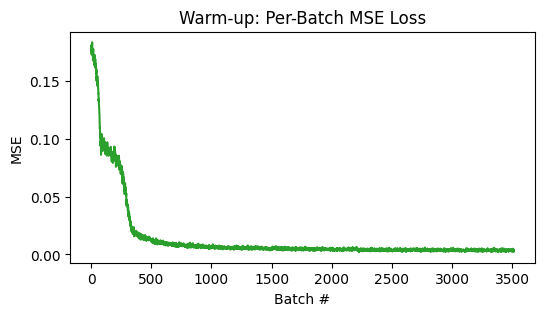

Epoch 1/10: 100%|██████████| 14063/14063 [04:00<00:00, 58.40it/s]


[Epoch 1]  Avg Loss: 0.0017  |  Avg PSNR: 27.83 dB


Epoch 2/10: 100%|██████████| 14063/14063 [03:59<00:00, 58.80it/s]


[Epoch 2]  Avg Loss: 0.0012  |  Avg PSNR: 29.32 dB


Epoch 3/10: 100%|██████████| 14063/14063 [04:04<00:00, 57.59it/s]


[Epoch 3]  Avg Loss: 0.0010  |  Avg PSNR: 30.35 dB


Epoch 4/10: 100%|██████████| 14063/14063 [04:07<00:00, 56.73it/s]


[Epoch 4]  Avg Loss: 0.0008  |  Avg PSNR: 31.18 dB


Epoch 5/10: 100%|██████████| 14063/14063 [04:08<00:00, 56.60it/s]


[Epoch 5]  Avg Loss: 0.0007  |  Avg PSNR: 32.00 dB


Epoch 6/10: 100%|██████████| 14063/14063 [04:06<00:00, 57.09it/s]


[Epoch 6]  Avg Loss: 0.0006  |  Avg PSNR: 32.34 dB


Epoch 7/10: 100%|██████████| 14063/14063 [04:05<00:00, 57.30it/s]


[Epoch 7]  Avg Loss: 0.0006  |  Avg PSNR: 32.65 dB


Epoch 8/10: 100%|██████████| 14063/14063 [04:15<00:00, 55.08it/s]


[Epoch 8]  Avg Loss: 0.0005  |  Avg PSNR: 32.92 dB


Epoch 9/10: 100%|██████████| 14063/14063 [04:16<00:00, 54.82it/s]


[Epoch 9]  Avg Loss: 0.0005  |  Avg PSNR: 33.17 dB


Epoch 10/10: 100%|██████████| 14063/14063 [04:15<00:00, 54.98it/s]

[Epoch 10]  Avg Loss: 0.0005  |  Avg PSNR: 33.57 dB


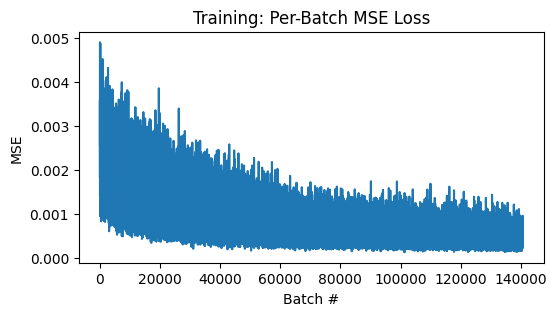

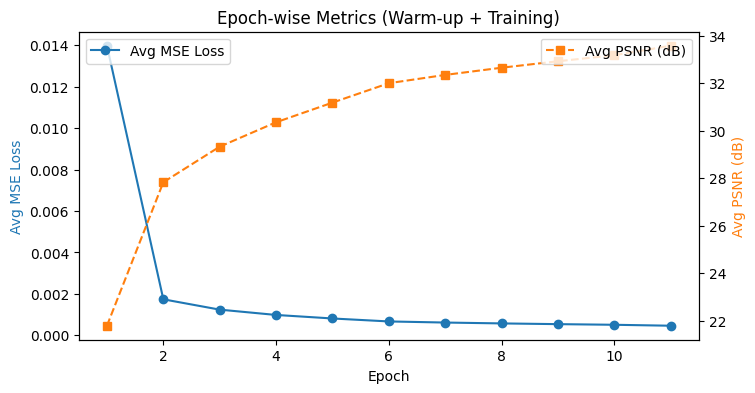

In [ ]:
import matplotlib.pyplot as plt

device = "cuda"

torch.manual_seed(42)
np.random.seed(42)

tn, tf = 8.0, 12.0
nb_epochs = 10
lr, gamma = 1e-4, 0.5
nb_bins = 100

model = Nerf(hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[5, 10], gamma=gamma
)

# --- Warm-up (1 epoch on the center-crop loader) ---
batch_wu, epoch_wu, psnr_wu = training(
    model,
    optimizer,
    scheduler,
    tn,
    tf,
    nb_bins,
    nb_epochs=1,
    data_loader=dataloader_warmup,
    device=device,
)

# Plot warm-up per-batch loss
plt.figure(figsize=(6, 3))
plt.plot(batch_wu, color="C2")
plt.title("Warm-up: Per-Batch MSE Loss")
plt.xlabel("Batch #")
plt.ylabel("MSE")
plt.show()

# --- Main training (full data) ---
batch_tr, epoch_tr, psnr_tr = training(
    model,
    optimizer,
    scheduler,
    tn,
    tf,
    nb_bins,
    nb_epochs=nb_epochs,
    data_loader=dataloader,
    device=device,
)

# Plot main per-batch loss
plt.figure(figsize=(6, 3))
plt.plot(batch_tr, color="C0")
plt.title("Training: Per-Batch MSE Loss")
plt.xlabel("Batch #")
plt.ylabel("MSE")
plt.show()

# Plot per-epoch averages & PSNR (combined warm-up + main)
all_epoch_losses = epoch_wu + epoch_tr
all_epoch_psnrs = psnr_wu + psnr_tr
epochs = list(range(1, 1 + len(all_epoch_losses)))

fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()
ax1.plot(epochs, all_epoch_losses, "-o", color="C0", label="Avg MSE Loss")
ax2.plot(epochs, all_epoch_psnrs, "--s", color="C1", label="Avg PSNR (dB)")

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Avg MSE Loss", color="C0")
ax2.set_ylabel("Avg PSNR (dB)", color="C1")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.title("Epoch-wise Metrics (Warm-up + Training)")
plt.show()

In [ ]:
torch.save(model.state_dict(), "./model_nerf_21602")

AttributeError: 'collections.OrderedDict' object has no attribute 'state_dict'

In [ ]:
model = Nerf(hidden_dim=128).to(device)
model.load_state_dict(torch.load("./model_nerf_21602"))
model.eval()

Nerf(
  (block1): Sequential(
    (0): Linear(in_features=63, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
  )
  (block2): Sequential(
    (0): Linear(in_features=191, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=129, bias=True)
  )
  (rgb_head): Sequential(
    (0): Linear(in_features=155, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True)
    (3): Sigmoid()
  )
)

## Here is demonstated that nerf can Reconstruct Pollen

In [ ]:
# import torch
import numpy as np
import matplotlib.pyplot as plt


def generate_novel_poses(radius=4.0, n_views=60, elev=0.0):
    """Generate camera poses on a circle around the origin."""
    poses = []
    for theta in np.linspace(0, 2 * np.pi, n_views):
        cam_origin = np.array([radius * np.sin(theta), elev, radius * np.cos(theta)])
        # Look at origin
        forward = -cam_origin / np.linalg.norm(cam_origin)
        up = np.array([0, 1, 0])
        right = np.cross(up, forward)
        up = np.cross(forward, right)
        pose = np.eye(4)
        pose[:3, 0] = right
        pose[:3, 1] = up
        pose[:3, 2] = forward
        pose[:3, 3] = cam_origin
        poses.append(pose)
    return np.stack(poses)


def get_rays_from_pose(pose, H, W, focal=400.0):
    """
    pose: (4,4) camera-to-world matrix
    H, W: image height and width
    focal: focal length (in pixels)
    Returns:
        o: (H*W, 3) ray origins
        d: (H*W, 3) ray directions
        dummy: placeholder (for compatibility)
    """
    i, j = np.meshgrid(np.arange(W), np.arange(H), indexing="xy")
    dirs = np.stack(
        [(i - W / 2) / focal, -(j - H / 2) / focal, -np.ones_like(i)], axis=-1
    )  # (H, W, 3)
    # Rotate ray directions from camera to world
    rays_d = (dirs[..., None, :] @ pose[:3, :3].T).squeeze(-2)  # (H, W, 3)
    rays_o = np.broadcast_to(pose[:3, 3], rays_d.shape)  # (H, W, 3)
    return rays_o, rays_d, None

In [ ]:
import mcubes
import trimesh
N = 100
scale = 1.5

x = torch.linspace(-scale, scale, N)
y = torch.linspace(-scale, scale, N)
z = torch.linspace(-scale, scale, N)

x, y, z = torch.meshgrid((x, y, z))
xyz = torch.cat((x.reshape(-1, 1),
                 y.reshape(-1, 1),
                 z.reshape(-1, 1)), dim=1)

with torch.no_grad():
    _, density = model.forward(xyz.to(device), torch.zeros_like(xyz).to(device))
    
density = density.cpu().numpy().reshape(N, N, N)
vertices, triangles = mcubes.marching_cubes(density, 2 * np.mean(density))
mesh = trimesh.Trimesh(vertices / N, triangles)
mesh.show()

In [ ]:
model = Nerf(hidden_dim=128).to(device)
model.load_state_dict(torch.load("./model_nerf_21602"))
model.eval()

Nerf(
  (block1): Sequential(
    (0): Linear(in_features=63, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
  )
  (block2): Sequential(
    (0): Linear(in_features=191, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=129, bias=True)
  )
  (rgb_head): Sequential(
    (0): Linear(in_features=155, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True)
    (3): Sigmoid()
  )
)

## How many Views does Nerf need


=== Object 17818 | training on 2 views ===


Epoch 1/2: 100%|██████████| 157/157 [00:04<00:00, 36.97it/s]


[Epoch 1]  Avg Loss: 0.0604  |  Avg PSNR: 13.30 dB


Epoch 2/2: 100%|██████████| 157/157 [00:03<00:00, 41.17it/s]


[Epoch 2]  Avg Loss: 0.0062  |  Avg PSNR: 22.36 dB
Finished training on 2 views.

>>> Obj 17818 | 2 views | test PSNR = 11.96 dB

=== Object 17818 | training on 3 views ===


Epoch 1/2: 100%|██████████| 235/235 [00:05<00:00, 43.88it/s]


[Epoch 1]  Avg Loss: 0.0551  |  Avg PSNR: 13.86 dB


Epoch 2/2: 100%|██████████| 235/235 [00:04<00:00, 47.88it/s]


[Epoch 2]  Avg Loss: 0.0068  |  Avg PSNR: 21.80 dB
Finished training on 3 views.

>>> Obj 17818 | 3 views | test PSNR = 13.90 dB

=== Object 17818 | training on 4 views ===


Epoch 1/2: 100%|██████████| 313/313 [00:05<00:00, 52.24it/s]


[Epoch 1]  Avg Loss: 0.0403  |  Avg PSNR: 16.67 dB


Epoch 2/2: 100%|██████████| 313/313 [00:05<00:00, 53.51it/s]


[Epoch 2]  Avg Loss: 0.0060  |  Avg PSNR: 22.25 dB
Finished training on 4 views.

>>> Obj 17818 | 4 views | test PSNR = 17.40 dB


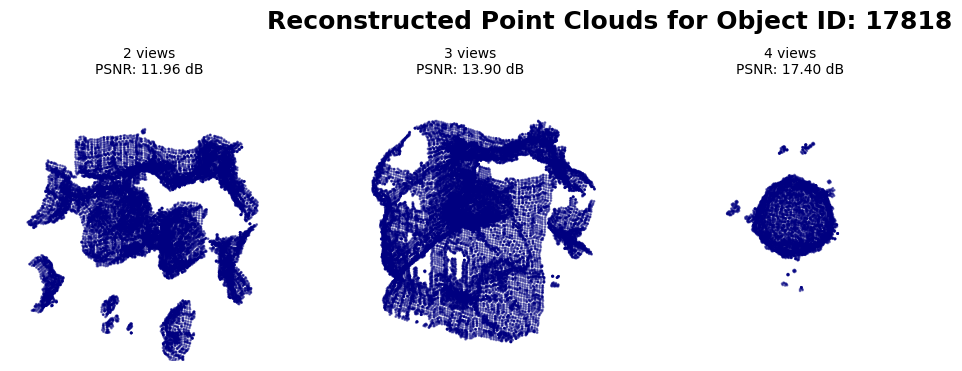


=== Object 17900 | training on 2 views ===


Epoch 1/2: 100%|██████████| 157/157 [00:03<00:00, 40.12it/s]


[Epoch 1]  Avg Loss: 0.0616  |  Avg PSNR: 12.90 dB


Epoch 2/2: 100%|██████████| 157/157 [00:03<00:00, 41.69it/s]


[Epoch 2]  Avg Loss: 0.0228  |  Avg PSNR: 16.48 dB
Finished training on 2 views.

>>> Obj 17900 | 2 views | test PSNR = 12.23 dB

=== Object 17900 | training on 3 views ===


Epoch 1/2: 100%|██████████| 235/235 [00:05<00:00, 40.15it/s]


[Epoch 1]  Avg Loss: 0.0573  |  Avg PSNR: 13.44 dB


Epoch 2/2: 100%|██████████| 235/235 [00:05<00:00, 44.59it/s]


[Epoch 2]  Avg Loss: 0.0177  |  Avg PSNR: 17.58 dB
Finished training on 3 views.

>>> Obj 17900 | 3 views | test PSNR = 13.87 dB

=== Object 17900 | training on 4 views ===


Epoch 1/2: 100%|██████████| 313/313 [00:07<00:00, 44.58it/s]


[Epoch 1]  Avg Loss: 0.0463  |  Avg PSNR: 15.08 dB


Epoch 2/2: 100%|██████████| 313/313 [00:07<00:00, 44.66it/s]


[Epoch 2]  Avg Loss: 0.0057  |  Avg PSNR: 22.47 dB
Finished training on 4 views.

>>> Obj 17900 | 4 views | test PSNR = 12.63 dB


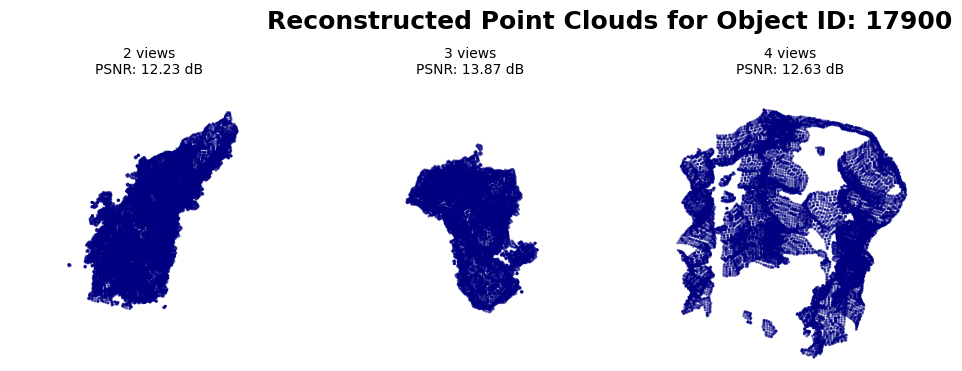


=== Object 20938 | training on 2 views ===


Epoch 1/2: 100%|██████████| 157/157 [00:03<00:00, 49.26it/s]


[Epoch 1]  Avg Loss: 0.0377  |  Avg PSNR: 14.25 dB


Epoch 2/2: 100%|██████████| 157/157 [00:03<00:00, 45.57it/s]


[Epoch 2]  Avg Loss: 0.0377  |  Avg PSNR: 14.25 dB
Finished training on 2 views.

>>> Obj 20938 | 2 views | test PSNR = 13.30 dB

=== Object 20938 | training on 3 views ===


Epoch 1/2: 100%|██████████| 235/235 [00:05<00:00, 40.61it/s]


[Epoch 1]  Avg Loss: 0.0504  |  Avg PSNR: 14.68 dB


Epoch 2/2: 100%|██████████| 235/235 [00:05<00:00, 40.46it/s]


[Epoch 2]  Avg Loss: 0.0030  |  Avg PSNR: 25.73 dB
Finished training on 3 views.

>>> Obj 20938 | 3 views | test PSNR = 15.32 dB

=== Object 20938 | training on 4 views ===


Epoch 1/2: 100%|██████████| 313/313 [00:07<00:00, 41.96it/s]


[Epoch 1]  Avg Loss: 0.0416  |  Avg PSNR: 14.15 dB


Epoch 2/2: 100%|██████████| 313/313 [00:07<00:00, 40.61it/s]


[Epoch 2]  Avg Loss: 0.0352  |  Avg PSNR: 14.74 dB
Finished training on 4 views.

>>> Obj 20938 | 4 views | test PSNR = 13.72 dB


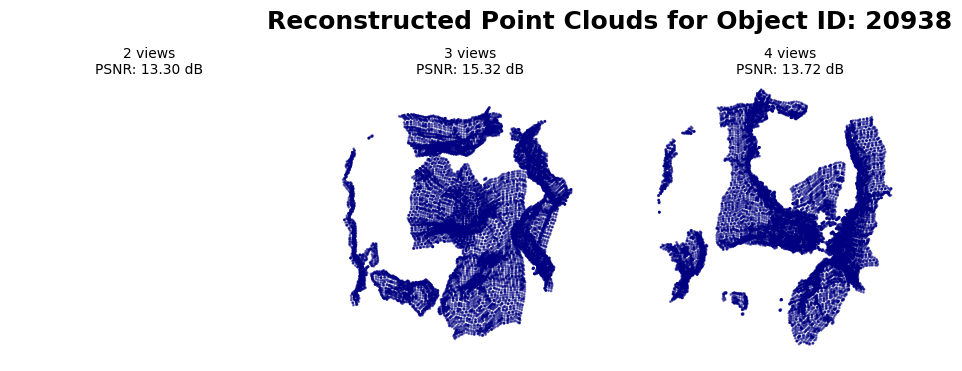


=== Object 17822 | training on 2 views ===


Epoch 1/2: 100%|██████████| 157/157 [00:04<00:00, 38.62it/s]


[Epoch 1]  Avg Loss: 0.0737  |  Avg PSNR: 12.09 dB


Epoch 2/2: 100%|██████████| 157/157 [00:03<00:00, 39.82it/s]


[Epoch 2]  Avg Loss: 0.0139  |  Avg PSNR: 18.79 dB
Finished training on 2 views.

>>> Obj 17822 | 2 views | test PSNR = 9.90 dB

=== Object 17822 | training on 3 views ===


Epoch 1/2: 100%|██████████| 235/235 [00:05<00:00, 40.87it/s]


[Epoch 1]  Avg Loss: 0.0676  |  Avg PSNR: 12.90 dB


Epoch 2/2: 100%|██████████| 235/235 [00:05<00:00, 39.79it/s]


[Epoch 2]  Avg Loss: 0.0109  |  Avg PSNR: 19.73 dB
Finished training on 3 views.

>>> Obj 17822 | 3 views | test PSNR = 13.74 dB

=== Object 17822 | training on 4 views ===


Epoch 1/2: 100%|██████████| 313/313 [00:08<00:00, 38.69it/s]


[Epoch 1]  Avg Loss: 0.0414  |  Avg PSNR: 15.63 dB


Epoch 2/2: 100%|██████████| 313/313 [00:07<00:00, 40.99it/s]


[Epoch 2]  Avg Loss: 0.0081  |  Avg PSNR: 20.95 dB
Finished training on 4 views.

>>> Obj 17822 | 4 views | test PSNR = 17.08 dB


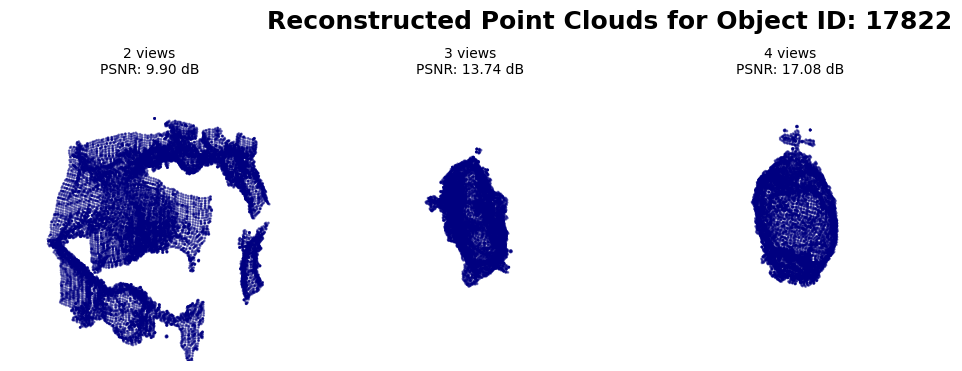

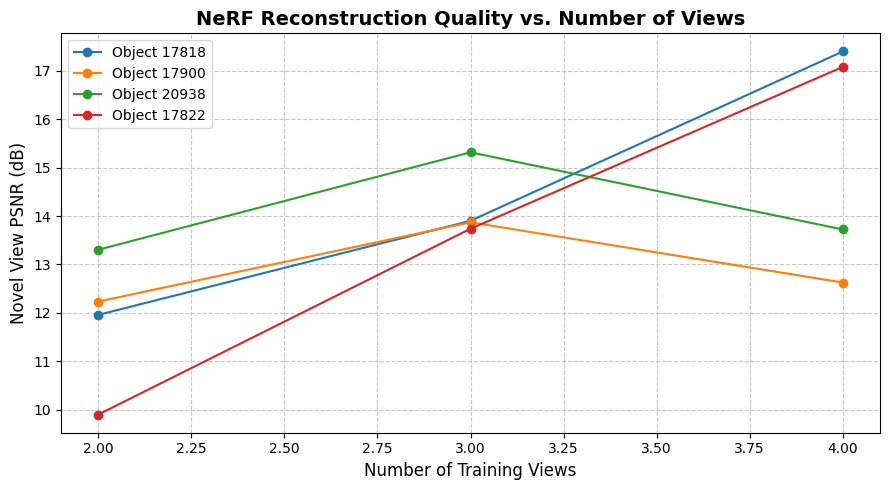

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from dataset_org import get_rays
from rendering import rendering
from model import Nerf
from ml_helpers import training
import mcubes

# -----------------------------------------------------------------------------
#  Utility: global PSNR over all pixels
# -----------------------------------------------------------------------------
def compute_global_psnr(model, dataloader_test, tn, tf, nb_bins, device, max_val=1.0):
    sum_sq_err = 0.0
    n_vals     = 0

    model.eval()
    with torch.no_grad():
        for batch in dataloader_test:
            o_test = batch[:, :3].to(device)
            d_test = batch[:, 3:6].to(device)
            t_test = batch[:, 6:9].to(device)

            rgb_pred = rendering(model, o_test, d_test, tn, tf, nb_bins, device=device)
            rgb_pred = rgb_pred.clamp(0.0, max_val)

            sum_sq_err += torch.sum((rgb_pred - t_test) ** 2).item()
            n_vals     += t_test.numel()

    mse   = sum_sq_err / n_vals
    psnr  = 10.0 * np.log10(max_val**2 / mse)
    return psnr

# -----------------------------------------------------------------------------
#  Main loop
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    view_counts = [2, 3, 4, 5, 6, 7, 8, 40, 60, 80, 100]
    object_ids  = ["17818", "17900", "20938", "17822"]

    results = {}
    cols    = 4

    for obj_id in object_ids:
        psnrs = []

        # make a fresh figure
        plt.close("all")
        num_views = len(view_counts)
        rows      = (num_views + cols - 1) // cols
        fig = plt.figure(figsize=(4 * cols, 4 * rows))
        fig.suptitle(f"Reconstructed Point Clouds for Object ID: {obj_id}",
                     fontsize=18, fontweight="bold", y=0.98)

        for idx, n_views in enumerate(view_counts):
            # --- load rays for this split of views ---
            data_dir = f"data/{obj_id}_views{n_views}"
            o, d, t           = get_rays(datapath=data_dir, mode="train")
            test_o, test_d, test_t = get_rays(datapath=data_dir, mode="test")

            # flatten into (N_rays, 9) tensors
            train_dataset = torch.cat([
                torch.from_numpy(o.reshape(-1,3)).float(),
                torch.from_numpy(d.reshape(-1,3)).float(),
                torch.from_numpy(t.reshape(-1,3)).float()
            ], dim=1)

            test_dataset = torch.cat([
                torch.from_numpy(test_o.reshape(-1,3)).float(),
                torch.from_numpy(test_d.reshape(-1,3)).float(),
                torch.from_numpy(test_t.reshape(-1,3)).float()
            ], dim=1)

            from torch.utils.data import DataLoader
            dataloader      = DataLoader(train_dataset, batch_size=2048, shuffle=True)
            dataloader_test = DataLoader(test_dataset,  batch_size=2048, shuffle=False)

            # --- instantiate & train ---
            model     = Nerf(hidden_dim=64).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
            scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                             milestones=[1],
                                                             gamma=0.5)
            tn, tf, nb_bins = 8.0, 12.0, 64

            print(f"\n=== Object {obj_id} | training on {n_views} views ===")
            _, _, train_psnr_list = training(
                model,
                optimizer,
                scheduler,
                tn, tf, nb_bins,
                nb_epochs=2,
                data_loader=dataloader,
                device=device,
            )
            print(f"Finished training on {n_views} views.\n")

            # --- compute global test PSNR ---
            test_psnr = compute_global_psnr(model,
                                           dataloader_test,
                                           tn, tf, nb_bins,
                                           device=device,
                                           max_val=1.0)
            psnrs.append(test_psnr)
            print(f">>> Obj {obj_id} | {n_views} views | test PSNR = {test_psnr:.2f} dB")

            # --- extract a point cloud via marching cubes ---
            N     = 64
            scale = 1.5
            grid  = torch.stack(torch.meshgrid(
                torch.linspace(-scale, scale, N),
                torch.linspace(-scale, scale, N),
                torch.linspace(-scale, scale, N),
                indexing="ij"
            ), dim=-1).view(-1,3)

            with torch.no_grad():
                _, density = model.forward(grid.to(device),
                                           torch.zeros_like(grid).to(device))
            density = density.cpu().numpy().reshape(N, N, N)

            try:
                verts, tris = mcubes.marching_cubes(
                    density, 2 * density.mean()
                )
                # re-scale to world coords
                verts = verts / (N - 1) * (2*scale) - scale
            except Exception:
                verts = np.zeros((0,3))
                tris  = np.zeros((0,3))

            # --- plot point cloud ---
            ax = fig.add_subplot(rows, cols, idx+1, projection="3d")
            if verts.shape[0] > 0:
                ax.scatter(verts[:,0], verts[:,1], verts[:,2],
                           s=1, alpha=0.5, c="navy")

                # equalize axes
                max_rng = (verts.max(axis=0) - verts.min(axis=0)).max() / 2
                mid     = verts.mean(axis=0)
                for i, axis in enumerate(["x","y","z"]):
                    getattr(ax, f"set_{axis}lim")(
                        mid[i]-max_rng, mid[i]+max_rng
                    )

            ax.set_title(f"{n_views} views\nPSNR: {test_psnr:.2f} dB",
                         fontsize=10, pad=6)
            ax.set_box_aspect([1,1,1])
            ax.axis("off")

        # finish figure
        fig.subplots_adjust(wspace=0.15, hspace=0.25,
                            top=0.88, bottom=0.02)
        plt.show()

        results[obj_id] = psnrs

    # --- final PSNR-vs-views plot ---
    plt.figure(figsize=(9,5))
    for obj_id in object_ids:
        plt.plot(view_counts, results[obj_id], "-o",
                 label=f"Object {obj_id}")
    plt.xlabel("Number of Training Views", fontsize=12)
    plt.ylabel("Novel View PSNR (dB)", fontsize=12)
    plt.title("NeRF Reconstruction Quality vs. Number of Views",
              fontsize=14, fontweight="bold")
    plt.legend()
    plt.grid(linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


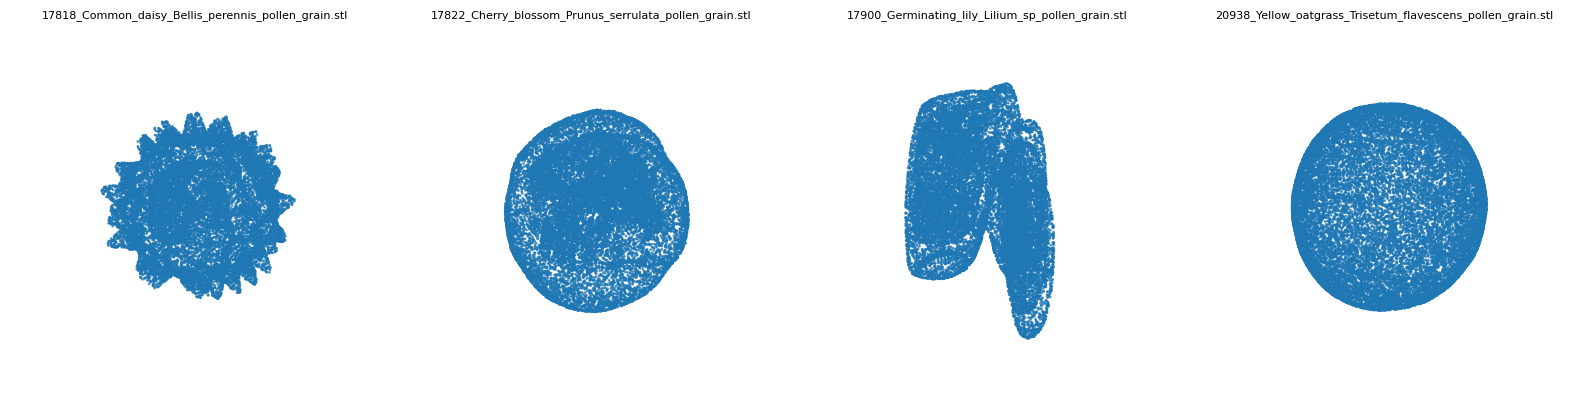

In [ ]:
import os
import glob
import trimesh
import matplotlib.pyplot as plt

stl_folder = './data/GT/'
stl_files = sorted(glob.glob(os.path.join(stl_folder, '*.stl')))

num_meshes = len(stl_files)
if num_meshes == 0:
    print("No STL files found.")
    exit()

# Grid size
cols = min(5, num_meshes)
rows = (num_meshes + cols - 1) // cols

fig = plt.figure(figsize=(4 * cols, 4 * rows))

for idx, mesh_file in enumerate(stl_files):
    mesh = trimesh.load(mesh_file)
    # Sample N points from the mesh surface
    points, _ = trimesh.sample.sample_surface(mesh, 22048)  # change 2048 as you like

    ax = fig.add_subplot(rows, cols, idx + 1, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, alpha=0.7)
    ax.set_title(os.path.basename(mesh_file), fontsize=8)
    ax.axis('off')
    ax.set_box_aspect([1,1,1])  # Equal aspect ratio

plt.tight_layout()
plt.show()


## Results


In my experiments, I found that NeRF requires at least <placeholder> input views per object to achieve a faithful 3D reconstruction. When I provided fewer views, the model was unable to accurately capture the geometry and appearance of the scene, resulting in blurry or "blobby" reconstructions that lacked structural detail. This observation aligns with the findings of Mildenhall et al. (2020), who showed that sparse view supervision often leads to ambiguous or incomplete reconstructions, particularly for complex shapes. Further, research such as RegNeRF (Niemeyer et al., 2022) confirms that dense multi-view coverage is essential for high-quality novel view synthesis and consistent 3D results. Therefore, I conclude that for practical 3D scene capture with NeRF, a sufficient number of diverse input views is crucial to avoid degenerate outputs.

Additionally, I observed that if the PSNR for novel views is not sufficiently high, it is not possible to extract a meaningful mesh from the NeRF representation. In such cases, any mesh extraction attempt results only in amorphous blobs rather than a faithful 3D surface. This further emphasizes the importance of achieving good generalization to novel views before attempting mesh extraction.

So Nerf is not made for the Task of two orthognal Sparse Views of pollen Grains.



**References:**
- Mildenhall, B., et al. (2020). [NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis](https://arxiv.org/abs/2003.08934)
- Niemeyer, M., et al. (2022). [RegNeRF: Regularizing Neural Radiance Fields for View Synthesis from Sparse Inputs](https://arxiv.org/abs/2112.00724)